This version use entropy/information of each word in allowed guesses to rank and choose which will be guess in next step. But the prob to be chosen will be depend on word frequency <br />
Some words have the prob to be answer likely equal, but the difference of frequency between them is too high. Answer ~ Common and conversely but not proportional exactly to frequency. At some threshold, all common words have the nearly same probability of being answer and vice versa. Hence, we use the frequenct into the signmoid function to classify two sets which are highly answers and lowly answers. In these sets, prob of words is similiar to each other

### Algorithm
1. Compute word frequency
2. Probability of being answer by logistic classification
3. Compute entropy of each word
4. Compare then choose guess for each step
5. Test and try related other algorithms

In [1]:

from math import *
import numpy as np
import json
with open('word_freq_ggdict.json') as file:
    word_freq_ggdict=json.load(file)
with open('allowed_guesses.txt','r') as file:
    allowed_guesses=[]
    for i in file:
        allowed_guesses.append(i[:5])
with open("real_possible_answers.txt","r") as file:
        real_possible_answers=[]
        for i in file:
            real_possible_answers.append(i[:5])


In [2]:
def sigmoid(x):
    return 1/(1+e**(-x))

In [3]:
def get_freq(word_freq_ggdict:list,CommonWord=3000,Width=10) -> dict:
    #make sorted word list by freq
    lst=list(word_freq_ggdict.items())
    lst.sort(key=lambda x: x[1])
    
    #add word into horizontal axis of sigmoid function
    N=len(word_freq_ggdict)
    metric = np.linspace(-Width*(N-CommonWord)/N,Width*CommonWord/N,N)
    priors=dict()
    for pair, unit in zip(lst,metric):
        priors[pair[0]]=sigmoid(unit)
    return priors
get_freq(word_freq_ggdict)['which']

0.9099212238487931

In [43]:
def get_feedback(guess:str,answer:str) -> list: 
    """
    get_feeback
    ----------
    guess: Five-letter guess.
    answer: Five-letter correct answer.
    Returns: Feedback contains 05 elements, which can be 0, 1, or 2, denoting a feedback pattern
    """
    # convert string to list
    answer = list(answer)
    guess = list(guess)
    
    #initialize
    feedback = ['']*5
    
    # isolate correctly placed letters
    for i in range(5):
        if guess[i] == answer[i]:
            feedback[i] = 2
            answer[i] = ''
            guess[i] = ''

    for i in range(5):
        if guess[i] == '': continue
        try:
            index=answer.index(guess[i])
            feedback[i] = 1
            answer[index] = ''
            guess[i] = ''
        except:
            feedback[i]=0
    return feedback


In [44]:
def reduce_list(guess:str,feedback:list,word_list:list) ->list:
    '''This function return the reduced allowed word list which have real answer
    
    guess: the word we guessed in this step
    feedback: the pattern given by game
    word_list: allowed list in the first step and the reduced list in the next steps
    '''
    return [word for word in word_list if get_feedback(guess,word)==feedback]



In [45]:
def convert_ternary(feedback):
    """
    Parameters
    ----------
    Feedback: Contains 05 elements, which can be 0, 1, or 2, denoting a feedback pattern.
    Returns
    -------
    Number: Integer base 10 representation of pattern.
    """
    return sum([feedback[i]*3**(4-i) for i in range(5)])
convert_ternary([1,2,0,0,2])

137

In [46]:
frequency=get_freq(word_freq_ggdict)
def entropy(guess:str, possible_answers:list):
    '''Function compute the entropy of each word which could be chosen in hard mode \n
    Return value of entropy(bits)'''
    Entropy=0
    pd_patterns = {} 
    total_freq=0
    for word in possible_answers:
        total_freq+=frequency[word]
    for word in possible_answers: 
        feedback = convert_ternary(get_feedback(guess,word))
        pd_patterns[feedback] = pd_patterns.get(feedback,0) +frequency[word]/total_freq
    for prob in pd_patterns.values():
        Entropy+=-prob*log2(prob)
    return Entropy
entropy('tares',allowed_guesses)


6.298081455163702

In [47]:
def entropy_dict(possible_answers):
    ranker=[]
    for guess in possible_answers:
        pair=(guess,entropy(guess,possible_answers))
        ranker.append(pair)
    ranker.sort(key=lambda x: x[1], reverse=True)
    return ranker




In [36]:

with open('firstguesses.json','w') as f:
    json.dump(entropy_dict(allowed_guesses),f)
with open('firstguesses.json','r') as f:
    file=json.load(f)
print(file[0])
#14s

['tares', 6.298081455163702]


In [51]:
def solution(answer,input=False):
    '''This function return the number of step in this play\n
    answer: The secret word of the game
    input : True is feedback inputted from terminal and vice versa
    '''
    k=0
    guess='tares'
    word_list=allowed_guesses
    while True:
        k+=1
        # print(guess)
        if input:
            feedback=[int(i) for i in str(input())]
        else:
            feedback=get_feedback(guess,answer)
        if feedback==[2]*5:
            break
        word_list=reduce_list(guess,feedback,word_list)
        guess=entropy_dict(word_list)[0][0]
    return k

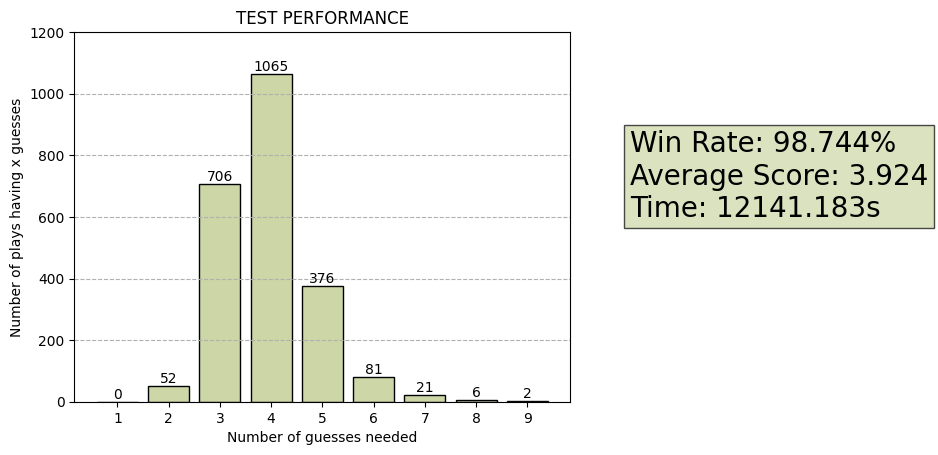

(98.74404504114335, 3.924209614551754)

In [52]:
def TestModel(solution,test_list:list,RANDOM=False) -> tuple:
    '''
    Parameter
    ----------
    solution: The function return the number of step to guess a specific answer \n
    test_list: The list of answers for testing
    RANDOM: False, answer is chosen randomly and True, answer is chosen sequentially from the test_list
    ----------
    Return: The bar chart with x(number of guesses needed) and y (number of plays having x guesses) \n
                  The tupple of winrate and average score'''
    import random
    import time
    t1=time.time()
    #Compute some vital factor: number of plays having x guesses, win rate, average score of 2,3k plays   
    xMax=20 # may be posituve infinity number
    yMax=0
    lst=[0]*xMax
    N=len(test_list)# list contains number of plays having x guesses
    for word in test_list:
        if not RANDOM:
            answer=word
        elif RANDOM:
            answer=random.choice(test_list)
        NumberOfGuessesNeeded=solution(answer) 
        lst[NumberOfGuessesNeeded]=lst[NumberOfGuessesNeeded]+1
    winrate=sum(lst[1:7])/N*100
    average=sum([i*lst[i] for i in range(1,xMax)]) / N

    #VISUALIZATION
    import matplotlib.pyplot as plt
    for i in range(1,xMax):
        if lst[i] >=yMax: # because yMax always in (1,6)
            yMax=lst[i]
        if lst[i]==0 and i>6:
            xMax=i
            break
    yMax=(yMax//100+2)*100
    x=[str(i) for i in range(1,xMax)]
    y=[i for i in lst[1:xMax]]
    plt.ylim(0,yMax)
    plt.grid(axis='y',linestyle='--')
    plt.xlabel('Number of guesses needed')
    plt.ylabel('Number of plays having x guesses')
    plt.title('TEST PERFORMANCE')
    plt.bar(x,y, fc="#CCD6A6", ec="black")
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha="center", va="bottom")
    t2=time.time()
    time=t2-t1
    plt.text(xMax,yMax/2, f'Win Rate: {winrate:.3f}%\nAverage Score: {average:.3f}\nTime: {time:.3f}s', fontsize = 20,
		bbox = dict(facecolor = '#CCD6A6', alpha = 0.7))
    plt.show()
    return winrate,average

TestModel(solution,real_possible_answers)
        
